In [1]:
import threading
from time import time
from heuristics_improvement import HeuristicRunData
from heuristics_constructive import Random
from heuristics_improvement import Basic
from moveSelectionStrategy import MoveSelectionStrategies
from paintshop import PaintShop, Source
from os import path

In [2]:


ps = PaintShop(Source.NOVEMBER)
generator = Random(ps)
# improver = Annealing(10)
improver = Basic(MoveSelectionStrategies.random)

# thread_counts = [1, 2, 4, 8, 16, 32, 64, 128]
parralellisms = [0, 1, 2, 4, 8, 16]
# parralellisms = [0, 1, 2]
# thread_counts = [1, 2, 4]
target_run_count = max(parralellisms)
# run_time = 10
verbosity = 0

[PaintShop] Loaded 'resources\PaintShop - November 2024.xlsx'


In [3]:
# Detect cache
from cache import cache_file_exists, ensuredir, load, save

dir = "multithreading_tests"
ensuredir(dir)
cache_file_path = path.join(dir, str(hash(
    (frozenset(parralellisms), str(improver), str(generator)))
))

if cache_file_exists(cache_file_path):
    
    data = load(cache_file_path)
    
else:
    
    # Dictionary to keep track of the data
    data: dict[int, dict] = {
        concurrency: {} for concurrency in parralellisms
    }

    # For each level of concurrency:
    for paralellism in parralellisms:

        # If no parallelism:
        if paralellism == 0:
            
            t0 = time()
            
            # Also do runs without thread API
            data[0]["runs"] = []
            for i in range(target_run_count):
                data[0]["runs"] += [improver.run(
                    HeuristicRunData(improver, generator.generate()),
                    verbosity
                )]
                
            data[0]["time"] = time() - t0
            
        # If yes parallelism
        else:
            
            # Amount of consectutive runs to reach target run count
            consecutive_count = target_run_count // paralellism 
        
            # Define function to run on thread
            def run_thread(thread_num):
                print(f'[{thread_num}] Thread started.')
                data[paralellism]["runs"] += [improver.run(
                    HeuristicRunData(paralellism, generator.generate()),
                    0
                )]
                print(f'[{thread_num}] Thread finished.')

            # initialize data
            data[paralellism]["runs"] = []
            t0 = time()
            
            # Run threads
            print(f"Running {consecutive_count} x {paralellism} threads.")
            for run_i in range(consecutive_count):
                
                # Create n_threads threads
                threads = [threading.Thread(
                    target=run_thread, 
                    args=([i])
                    ) for i in range(paralellism)]
            
                # Start threads
                for thread in threads:
                    thread.start()
                    
                # Join threads
                for thread in threads:
                    thread.join()
                    
                print(f"Finished meta run {run_i}.")

            data[paralellism]["time"] = time() - t0
            
    save(data, cache_file_path, overwrite = True),

Running 16 x 1 threads.
[0] Thread started.
[0] Thread finished.
Finished meta run 0.
[0] Thread started.
[0] Thread finished.
Finished meta run 1.
[0] Thread started.
[0] Thread finished.
Finished meta run 2.
[0] Thread started.
[0] Thread finished.
Finished meta run 3.
[0] Thread started.
[0] Thread finished.
Finished meta run 4.
[0] Thread started.
[0] Thread finished.
Finished meta run 5.
[0] Thread started.
[0] Thread finished.
Finished meta run 6.
[0] Thread started.
[0] Thread finished.
Finished meta run 7.
[0] Thread started.
[0] Thread finished.
Finished meta run 8.
[0] Thread started.
[0] Thread finished.
Finished meta run 9.
[0] Thread started.
[0] Thread finished.
Finished meta run 10.
[0] Thread started.
[0] Thread finished.
Finished meta run 11.
[0] Thread started.
[0] Thread finished.
Finished meta run 12.
[0] Thread started.
[0] Thread finished.
Finished meta run 13.
[0] Thread started.
[0] Thread finished.
Finished meta run 14.
[0] Thread started.
[0] Thread finished.


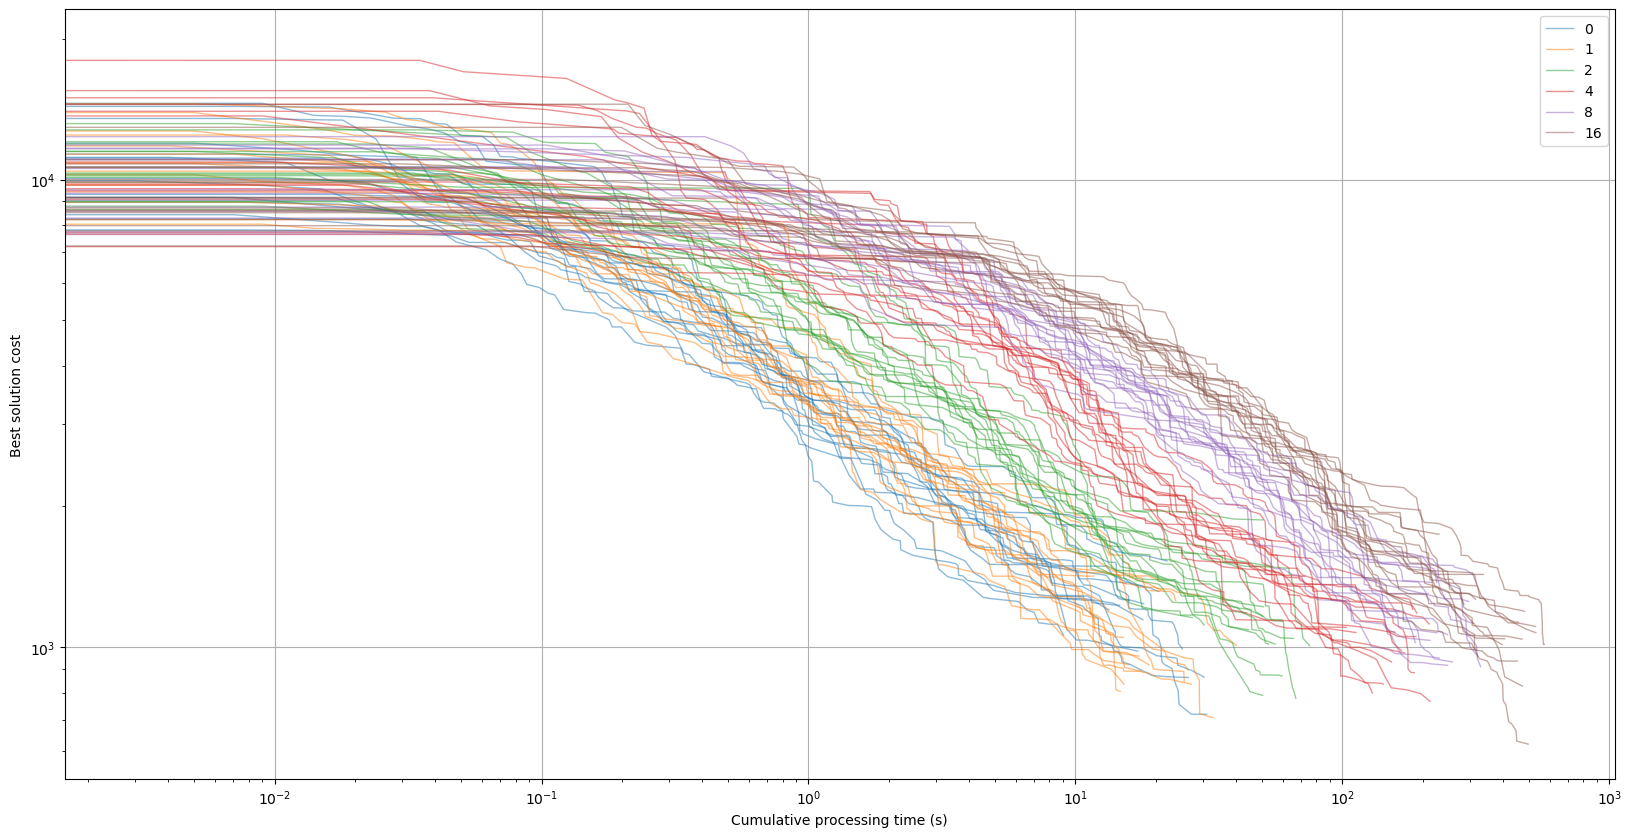

In [6]:
from matplotlib import pyplot as plt


plt.figure(figsize=(20,10))

improver_colors = {}

for paralellism, p_data in data.items():
    
    for ri, run in enumerate(p_data["runs"]):
        
        # Calculate running best
        running_best_cost = []
        for i in run.iterations:
            if len(running_best_cost) < 1 or i.cost < running_best_cost[-1]:
                running_best_cost.append(i.cost)
            else:
                running_best_cost.append(running_best_cost[-1])

        if ri > 0:
            color = improver_colors[paralellism]
            plt.plot([iter.time for iter in run.iterations], running_best_cost, linewidth = 1, alpha = 0.5, color = color)
        else:
            color = next(plt.gca()._get_lines.prop_cycler)['color']
            # color = next(plt.gca()._get_lines.color_cycle)
            improver_colors[paralellism] = color
            plt.plot([iter.time for iter in run.iterations], running_best_cost, linewidth = 1, alpha = .5, color = color, label = f'{paralellism}')

        # plt.plot([iter.time for iter in run_data.iterations], [iter.cost for iter in run_data.iterations], '.', label = f'{run}', color = color)
        # if first_run_of_improver:
        #     plt.plot([iter.time for iter in run.iterations], running_best_cost, linewidth = 2, alpha = 1, color = color, label = f'{improver}')
        # else:
        #     plt.plot([iter.time for iter in run.iterations], running_best_cost, linewidth = 2, alpha = 1, color = color)
    
        
plt.xlabel('Cumulative processing time (s)')
plt.ylabel('Best solution cost')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

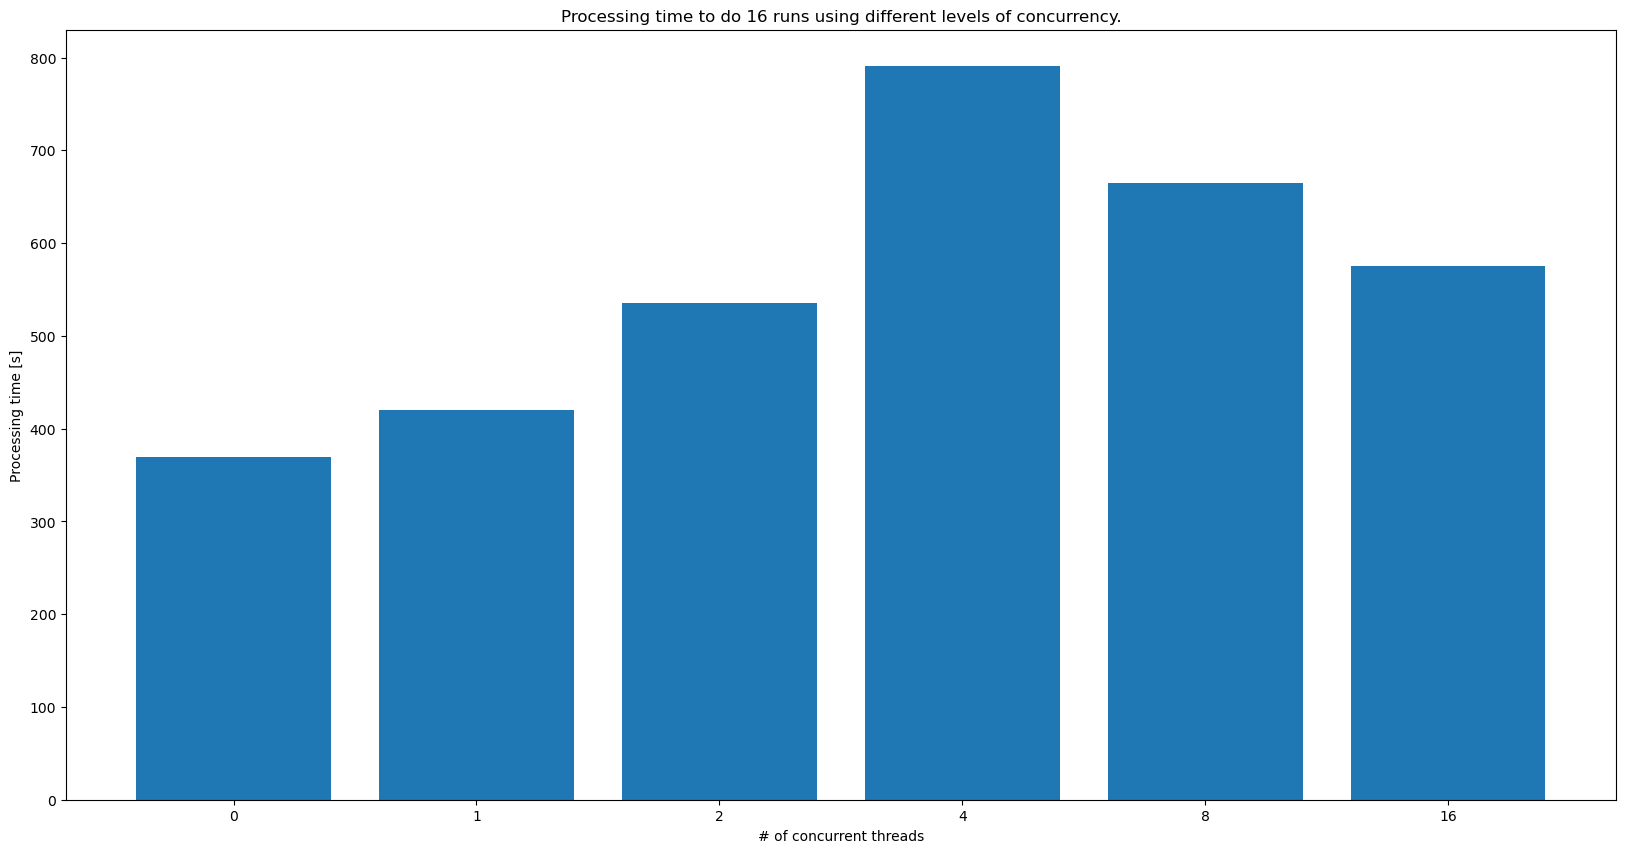

In [7]:
from numpy import mean, median

plt.figure(figsize=(20,10))
# plt.grid()

# sorted_runs_data = {item[0]: item[1] for item in sorted(data.items(), key = lambda item: item[0])}

plt.title(f"Processing time to do {target_run_count} runs using different levels of concurrency.")
plt.bar(range(len(data.keys())), [pd["time"] for pd in data.values()])
plt.xticks(range(len(data.keys())), data.keys())
plt.xlabel('# of concurrent threads')
plt.ylabel('Processing time [s]')
plt.show()